In [262]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

from chinese_calendar import is_holiday, is_workday, is_in_lieu

In [263]:
dataset_h = pd.read_csv('./hourly_dataset.csv') #每小时间隔流量数据集，含20个小区（01-20），多个表格间对于小区的编码一致
sub       = pd.read_csv('./sample_submission.csv') #提交样例
test      = pd.read_csv('./test_public.csv') #测试集（小时单位），须提交20个小区、4个不连续周的供水量。也即672（小时数） x 20（小区数）的矩阵
weather   = pd.read_csv('./weather.csv') #深圳市天气数据，测试集部分假定未知

In [264]:
def time_transfer(df):
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values(by=['time'])
    return df



def handle_outlier(dataset):
    
    for i in range(20):
        col = dataset.loc[:, f'flow_{i+1}']

        col[col<0] = np.nan
    
        mean = col.mean()
        std = col.std()
        col[col >= mean + 3*std] = np.nan
        col[col >= mean + 2*std] = np.nan

        mean = col.mean()
        col.fillna(mean, inplace=True)

        dataset.loc[:, f'flow_{i+1}'] = col

        
    
    return dataset
    



def process_time_features(orign_feas, flow):
    new_feas = pd.DataFrame(orign_feas.loc[:,'time'])

    # 小时
    new_feas['hour'] = orign_feas['time'].apply(lambda x: x.hour)
    
    # 日
    new_feas['day'] = orign_feas['time'].apply(lambda x: x.day)

    # 月
    new_feas['month'] = orign_feas['time'].apply(lambda x: x.month)
    
    # 星期
    new_feas['day_of_week'] = orign_feas['time'].apply(lambda x: x.dayofweek)

    # 期间段
    period_of_day_dict = {
        23: 0, 0: 0, 1: 0,
        2: 1, 3: 1, 4: 1,
        5: 2, 6: 2, 7: 2,
        8: 3, 9: 3, 10: 3, 11: 3,
        12: 4, 13: 4, 14: 4,
        15: 5, 16: 5,
        17: 6, 18: 6,19: 6,
        20: 7, 21: 7, 22: 7,
    }
    new_feas['period_of_day'] = new_feas['hour'].map(period_of_day_dict)

    # 是否营业时间
    new_feas['work_hours'] = orign_feas['time'].apply(lambda x: 0 if x.hour >= 8 and x.hour <= 21 else 1)

    # 假期
    new_feas['holiday'] = orign_feas['time'].apply(is_holiday).astype('int')
    
    # 不调休
    new_feas['lieu'] = orign_feas['time'].apply(is_in_lieu).astype('int')

    # 是否月初
    new_feas['month_start'] = orign_feas['time'].apply(lambda x: x.is_month_start).astype('int')

    # 是否月末
    new_feas['month_end'] = orign_feas['time'].apply(lambda x: x.is_month_end).astype('int')

    # 季节
    new_feas['season'] = orign_feas['time'].apply(lambda x: x.quarter)

    new_feas = new_feas.drop(['time'],axis=1)
    
    return new_feas

    
'''
origin_feas: features of each community, the size is n*2, including 'time', 'flow_i'
flow: index of community 
'''
def process_data_features(orign_feas, flow):
    new_features = pd.DataFrame()

    # 差值
    new_features[f'{flow}_diff_1'] = orign_feas[flow].diff().shift(1)
    new_features[f"{flow}_diff_24"] = orign_feas[flow].diff(24).shift(1)
    new_features[f"{flow}_diff_168"] = orign_feas[flow].diff(24*7).shift(1)

    # 前面的值
    for i in range(1, 25):
        new_features[f"{flow}_shift_{i}"] = orign_feas[flow].shift(i)


    new_features[f"{flow}_shift_48"] = orign_feas[flow].shift(48)
    new_features[f"{flow}_shift_72"] = orign_feas[flow].shift(72)
    new_features[f"{flow}_shift_96"] = orign_feas[flow].shift(96)
    new_features[f"{flow}_shift_120"] = orign_feas[flow].shift(120)
    new_features[f"{flow}_shift_144"] = orign_feas[flow].shift(144)
    new_features[f"{flow}_shift_168"] = orign_feas[flow].shift(168)


    # 周期特征
    de_resl = seasonal_decompose(orign_feas[flow],freq=24)
    new_features[f"{flow}_trend_1"] = de_resl.trend.shift(1)
    new_features[f"{flow}_trend_2"] = de_resl.trend.shift(2)
    new_features[f"{flow}_trend_3"] = de_resl.trend.shift(3)
    new_features[f"{flow}_trend_4"] = de_resl.trend.shift(4)
    new_features[f"{flow}_trend_5"] = de_resl.trend.shift(5)
    new_features[f"{flow}_trend_6"] = de_resl.trend.shift(6)
    new_features[f"{flow}_trend_7"] = de_resl.trend.shift(7)



    new_features[f"{flow}_seas_1"] = de_resl.seasonal.shift(1)
    new_features[f"{flow}_seas_2"] = de_resl.seasonal.shift(2)
    new_features[f"{flow}_seas_3"] = de_resl.seasonal.shift(3)
    new_features[f"{flow}_seas_4"] = de_resl.seasonal.shift(4)
    new_features[f"{flow}_seas_5"] = de_resl.seasonal.shift(5)
    new_features[f"{flow}_seas_6"] = de_resl.seasonal.shift(6)
    new_features[f"{flow}_seas_7"] = de_resl.seasonal.shift(7)

    new_features[f"{flow}_seas_24"] = de_resl.seasonal.shift(48)
    new_features[f"{flow}_seas_48"] = de_resl.seasonal.shift(48)
    new_features[f"{flow}_seas_72"] = de_resl.seasonal.shift(72)
    new_features[f"{flow}_seas_96"] = de_resl.seasonal.shift(96)
    new_features[f"{flow}_seas_120"] = de_resl.seasonal.shift(120)
    new_features[f"{flow}_seas_144"] = de_resl.seasonal.shift(144)
    new_features[f"{flow}_seas_168"] = de_resl.seasonal.shift(168)



    return new_features.interpolate().fillna(method='ffill')



# 特征工程
def make_features(data):
    data = data.drop(['train or test'],axis=1)
    community_list = []

    
    for flow in tqdm(range(20)):
        # 添加初始特征
        features_list = []  
        features_list.append(pd.DataFrame(data.loc[:,[f'flow_{flow+1}']]))
        
        # cls_feature = pd.DataFrame(np.zeros((data.shape[0],5)), columns=[f'cls_{i}' for i in range(5)])
        # cls_list = [f'cls_{i}' for i in range(5) if (int(flow / (2**i)) % 2 == 1)]
        # cls_feature.loc[:, cls_list] = 1
        # features_list.append(cls_feature)

        # 未处理特征 n*2: time | flow_i
        orign_features = pd.DataFrame(data.loc[:,['time',f'flow_{flow+1}']])
    
        # 添加时间特征
        features_list.append(process_time_features(orign_features, f'flow_{flow+1}'))

        # 添加数据特征
        features_list.append(process_data_features(orign_features, f'flow_{flow+1}'))

        fea_name_list = [fea for feas in features_list for fea in list(feas)]
            
        # n, c
        new_features = np.concatenate(features_list, axis=-1)
        
        community_list.append(new_features)

    # n*d*c
    new_data = np.stack(community_list,axis=0).transpose(1,0,2)

    return new_data, fea_name_list


def generate_dataset(data, seq_len, pre_len, split_ratio=0.8):
    # train_x, train_y, val_x, val_y, test_x = [], [], [], [], np.expand_dims(data[-pre_len:],axis=[0])
    # split_size = int(len(data)*split_ratio)
    # train_data = data[:split_size]
    # val_data   = data[split_size:]
    # for i in range(0, len(train_data)-seq_len-pre_len, seq_len):    
    #     train_x.append(train_data[i:i+seq_len])
    #     train_y.append(train_data[i+seq_len:i+seq_len+pre_len])
    # for i in range(0, len(val_data)-seq_len-pre_len, seq_len):
    #     val_x.append(val_data[i:i+seq_len])
    #     val_y.append(val_data[i+seq_len:i+seq_len+pre_len])
    # train_x, train_y, val_x, val_y = np.array(train_x), np.array(train_y), np.array(val_x), np.array(val_y)


    train_x, train_y, val_x, val_y, test_x = [], [], [], [], np.expand_dims(data[-pre_len:],axis=[0])

    train_data = data[:-7*24]
    val_data   = data[-7*24:]
    for i in range(0, len(train_data)):    
        train_x.append(train_data[i])
        train_y.append(train_data[i])

    for i in range(0, len(val_data)):    
        val_x.append(val_data[i])
        val_y.append(val_data[i])
    

    train_x, train_y, val_x, val_y = np.array(train_x), np.array(train_y), np.array(val_x), np.array(val_y)

    test_x = val_x

    return train_x, train_y, val_x, val_y, test_x



def lightgbm_train(train_x, train_y, val_x, val_y, test_x):
    fea_nums = train_x.shape[-1]
    scores = []
    predictions = []
    lgb_model_list = []
    for flow in tqdm(range(20)):
        # train_data_x = pd.DataFrame(train_x[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,1:]
        # train_data_y = pd.DataFrame(train_y[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,0]
        # val_data_x   = pd.DataFrame(val_x[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,1:]
        # val_data_y   = pd.DataFrame(val_y[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,0]
        # test_data_x  = pd.DataFrame(test_x[:, :, flow, :].reshape(-1, fea_nums)).iloc[:,1:]

        train_data_x = pd.DataFrame(train_x[:, flow, :].reshape(-1, fea_nums)).iloc[:,1:]
        train_data_y = pd.DataFrame(train_y[ :, flow, :].reshape(-1, fea_nums)).iloc[:,0]
        val_data_x   = pd.DataFrame(val_x[ :, flow, :].reshape(-1, fea_nums)).iloc[:,1:]
        val_data_y   = pd.DataFrame(val_y[ :, flow, :].reshape(-1, fea_nums)).iloc[:,0]
        test_data_x  = pd.DataFrame(test_x[ :, flow, :].reshape(-1, fea_nums)).iloc[:,1:]
        

        train_part = lgb.Dataset(train_data_x, train_data_y)
        val_part = lgb.Dataset(val_data_x, val_data_y)
        ESR = 100
        NBR = 3000
        VBE = 100
        lgb_params_best = {'objective': 'regression',
                           'metric': ['mse'],
                           'bagging_seed': 2022,
                           'verbose': -1}
        lgb_model = lgb.train(lgb_params_best, train_part, num_boost_round=NBR,
                              valid_sets=[train_part, val_part],
                              valid_names=['train', 'valid'],
                              early_stopping_rounds=ESR, verbose_eval=None)
        lgb_model_list.append(lgb_model)
        pre_x = lgb_model.predict(val_data_x)
        pre_x = [ x if x > 0 else 0 for x in pre_x] 
        score = mean_squared_log_error(val_data_y, pre_x)
        scores.append(round(score, 3))
        prediction_test = lgb_model.predict(test_data_x)
        predictions.append(prediction_test)

    
    return predictions, scores, lgb_model_list
    

In [265]:
dataset_h = time_transfer(dataset_h)
test = time_transfer(test)


In [266]:
test_timestamp_start = test.groupby('train or test')['time'].first().reset_index()
test_timestamp_start = test_timestamp_start['time'].values
test_timestamp_end = test.groupby('train or test')['time'].last().reset_index()
test_timestamp_end = test_timestamp_end['time'].values
test_timestamp = np.concatenate((test_timestamp_start, test_timestamp_end), axis=0)
test_timestamp.sort()


# dataset part1
dataset_train_p1 = dataset_h[dataset_h['time']<test_timestamp[0]].reset_index(drop=True)
dataset_test_p1  = dataset_h[(dataset_h['time']>=test_timestamp[0]) & (dataset_h['time']<=test_timestamp[1])].reset_index(drop=True)

# dataset part2
dataset_train_p2 = dataset_h[(dataset_h['time']>test_timestamp[1])  & (dataset_h['time']<test_timestamp[2])].reset_index(drop=True)
dataset_test_p2  = dataset_h[(dataset_h['time']>=test_timestamp[2]) & (dataset_h['time']<=test_timestamp[3])].reset_index(drop=True)

#dataset part3
dataset_train_p3 = dataset_h[(dataset_h['time']>test_timestamp[3])  & (dataset_h['time']<test_timestamp[4])].reset_index(drop=True)
dataset_test_p3  = dataset_h[(dataset_h['time']>=test_timestamp[4]) & (dataset_h['time']<=test_timestamp[5])].reset_index(drop=True)

#dataset part4
dataset_train_p4 = dataset_h[(dataset_h['time']>test_timestamp[5])  & (dataset_h['time']<test_timestamp[6])].reset_index(drop=True)
dataset_test_p4  = dataset_h[(dataset_h['time']>=test_timestamp[6]) & (dataset_h['time']<=test_timestamp[7])].reset_index(drop=True)



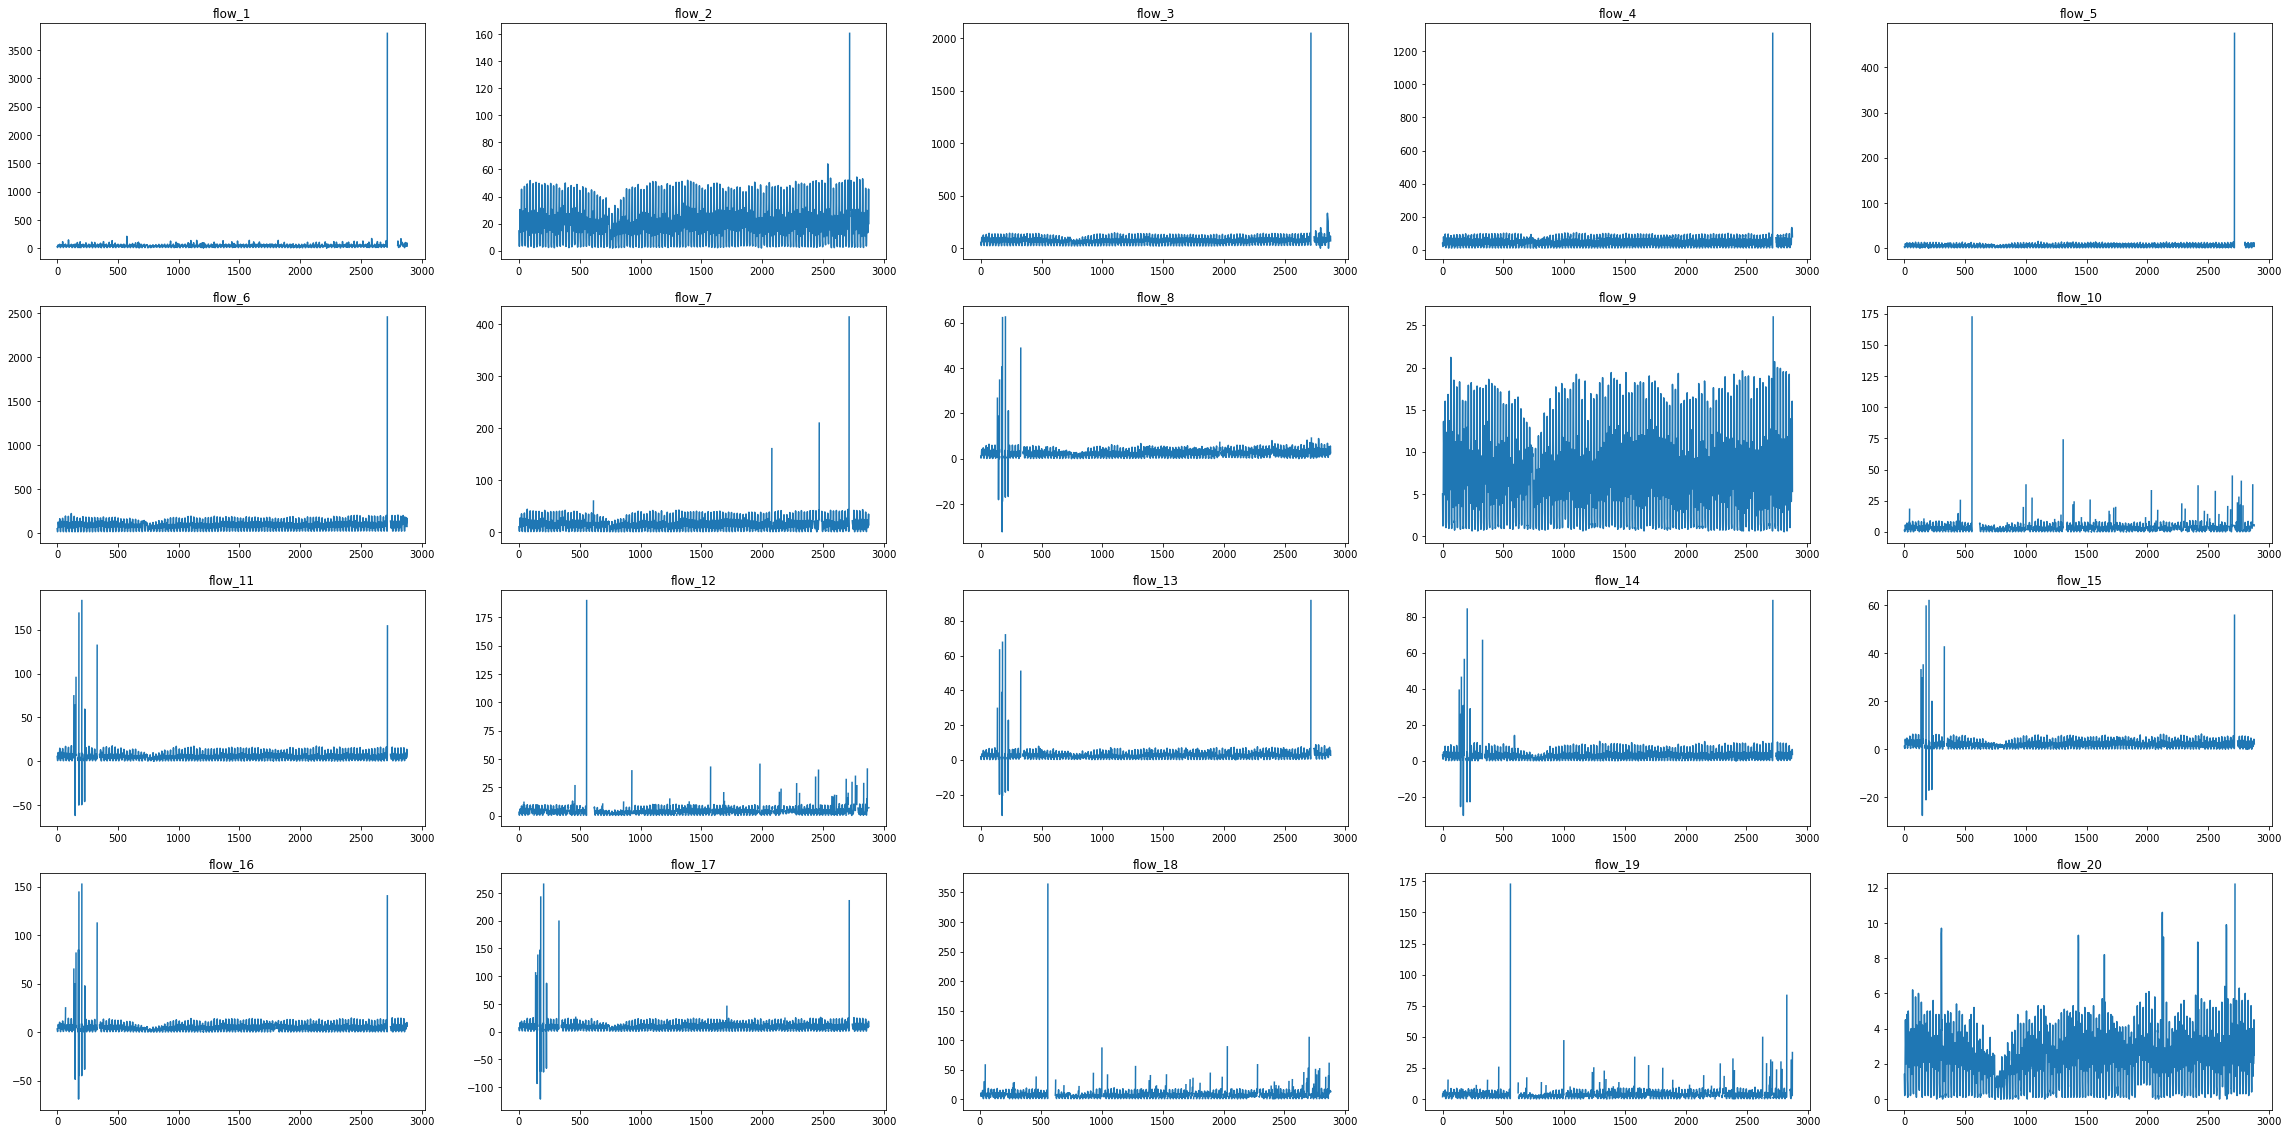

In [267]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 20))

for i in range(1,21):
    flow = f'flow_{i}'
    plt.subplot(4, 5, i)
    plt.plot(range(len(dataset_train_p1[flow])), dataset_train_p1[flow])
    plt.title(flow)

In [268]:
# 处理Nan
dataset_train_p1 = handle_outlier(dataset_train_p1)
dataset_train_p2 = handle_outlier(dataset_train_p2)
dataset_train_p3 = handle_outlier(dataset_train_p3)
dataset_train_p4 = handle_outlier(dataset_train_p4)

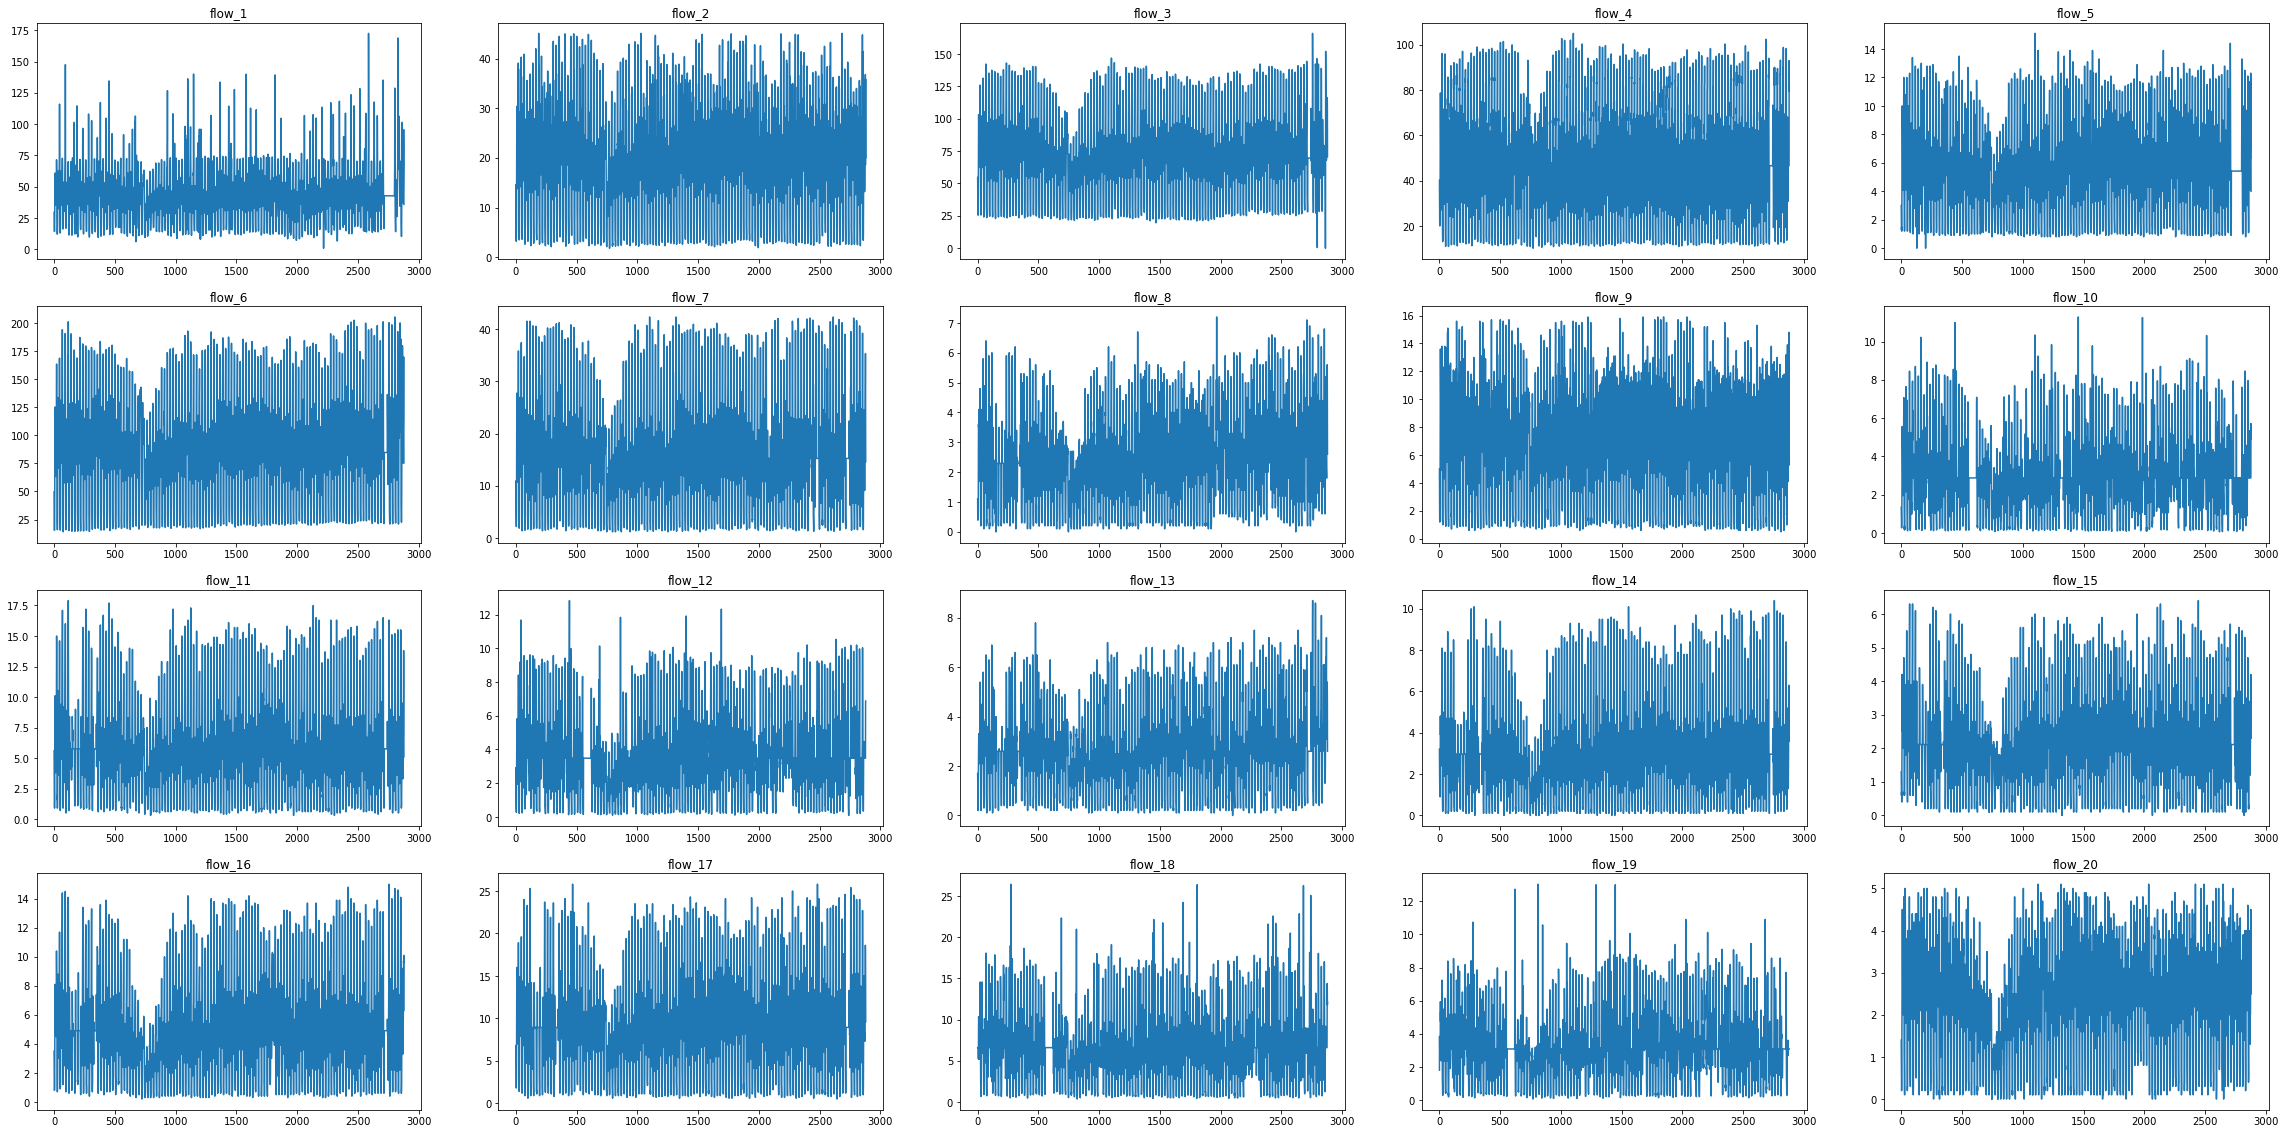

In [269]:
plt.figure(figsize=(40, 20))

for i in range(1,21):
    flow = f'flow_{i}'
    plt.subplot(4, 5, i)
    plt.plot(range(len(dataset_train_p1[flow])), dataset_train_p1[flow])
    plt.title(flow)

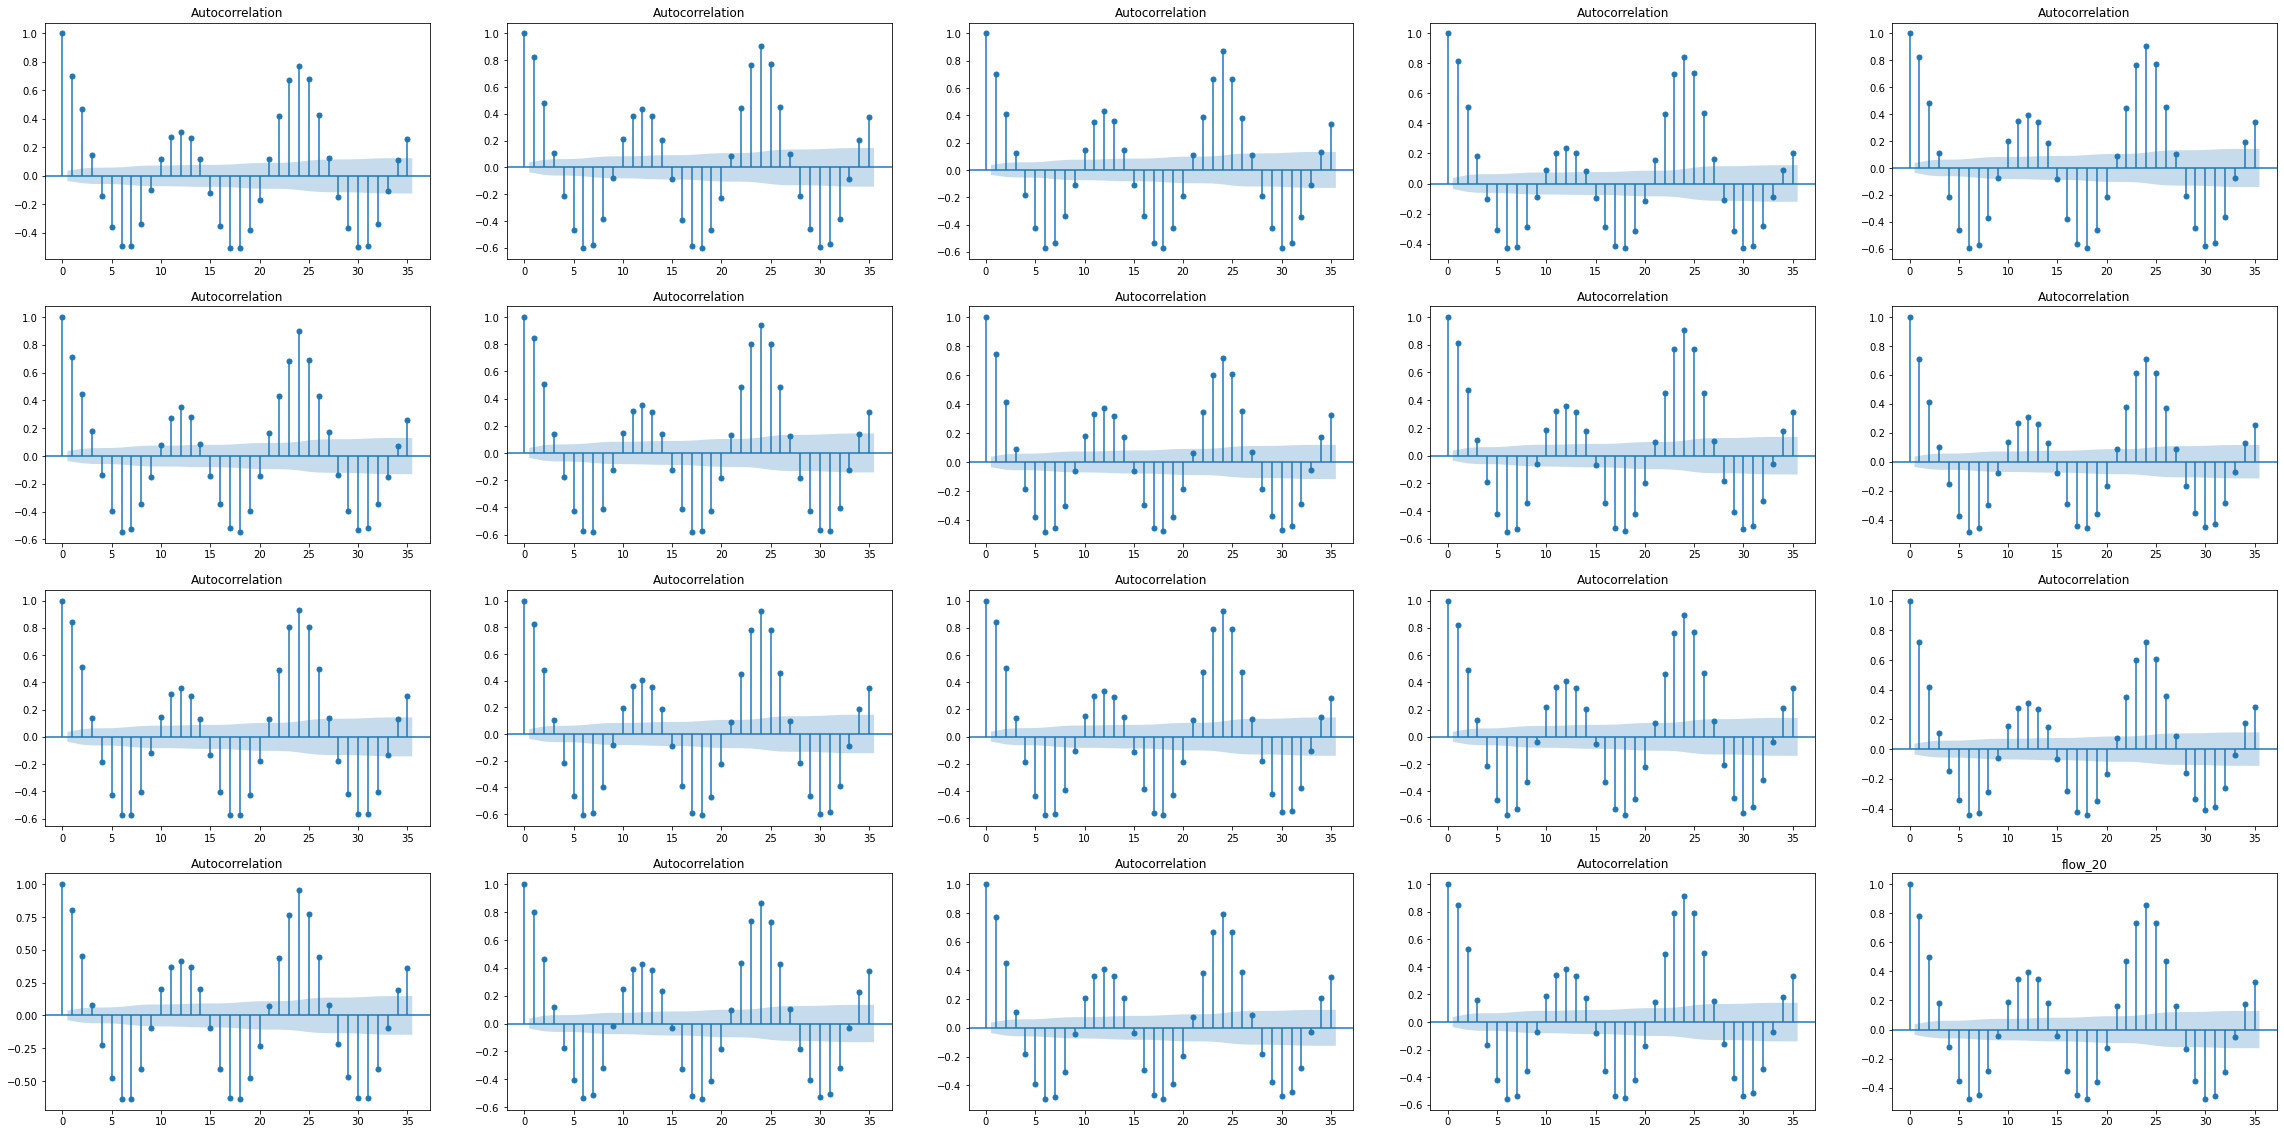

In [270]:
from statsmodels.graphics.tsaplots import plot_acf
# plt.figure(figsize=(40, 20))
fig, ax = plt.subplots(4, 5, figsize=(40, 20))

for i in range(1,21):
    flow = f'flow_{i}'
    # plt.subplot(4, 5, i)
    plot_acf(dataset_train_p1[flow],ax=ax[int((i-1)%4)][int((i-1)/4)])
    plt.title(flow)


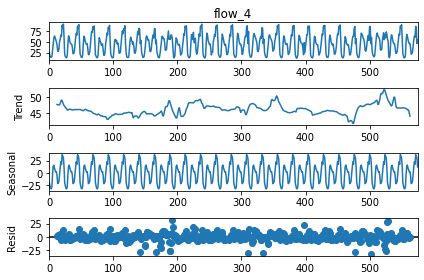

In [271]:
from statsmodels.tsa.seasonal import seasonal_decompose


flow = f'flow_{4}'
ts_decomposition = seasonal_decompose(dataset_train_p2[flow], freq=24)
ts_decomposition.plot()
plt.show()


In [272]:
# 构建特征
features_p1, fn_list = make_features(dataset_train_p1)
features_p12, _ = make_features(pd.concat([dataset_train_p1,dataset_train_p2]))
features_p123,_ = make_features(pd.concat([dataset_train_p1,dataset_train_p2,dataset_train_p3]))
features_p1234,_ = make_features(pd.concat([dataset_train_p1,dataset_train_p2,dataset_train_p3,dataset_train_p4]))
fn_list = {i:fn_list[i] for i in  range(len(fn_list))}
print(fn_list)



100%|██████████| 20/20 [00:08<00:00,  2.45it/s]

{0: 'flow_20', 1: 'hour', 2: 'day', 3: 'month', 4: 'day_of_week', 5: 'period_of_day', 6: 'work_hours', 7: 'holiday', 8: 'lieu', 9: 'month_start', 10: 'month_end', 11: 'season', 12: 'flow_20_diff_1', 13: 'flow_20_diff_24', 14: 'flow_20_diff_168', 15: 'flow_20_shift_1', 16: 'flow_20_shift_2', 17: 'flow_20_shift_3', 18: 'flow_20_shift_4', 19: 'flow_20_shift_5', 20: 'flow_20_shift_6', 21: 'flow_20_shift_7', 22: 'flow_20_shift_8', 23: 'flow_20_shift_9', 24: 'flow_20_shift_10', 25: 'flow_20_shift_11', 26: 'flow_20_shift_12', 27: 'flow_20_shift_13', 28: 'flow_20_shift_14', 29: 'flow_20_shift_15', 30: 'flow_20_shift_16', 31: 'flow_20_shift_17', 32: 'flow_20_shift_18', 33: 'flow_20_shift_19', 34: 'flow_20_shift_20', 35: 'flow_20_shift_21', 36: 'flow_20_shift_22', 37: 'flow_20_shift_23', 38: 'flow_20_shift_24', 39: 'flow_20_shift_48', 40: 'flow_20_shift_72', 41: 'flow_20_shift_96', 42: 'flow_20_shift_120', 43: 'flow_20_shift_144', 44: 'flow_20_shift_168', 45: 'flow_20_trend_1', 46: 'flow_20_tren

In [273]:
features_p1.shape

(2880, 20, 66)

In [274]:
# 构造x和y数据
train1_x, train1_y, val1_x, val1_y, test1_x = generate_dataset(features_p1, 24*7, 24*7)
train2_x, train2_y, val2_x, val2_y, test2_x = generate_dataset(features_p12, 24*7, 24*7)
train3_x, train3_y, val3_x, val3_y, test3_x = generate_dataset(features_p123, 24*7, 24*7)
train4_x, train4_y, val4_x, val4_y, test4_x = generate_dataset(features_p1234, 24*7, 24*7)

In [275]:
print(train1_x.shape)
print(train1_y.shape)
print(val1_x.shape)
print(val1_y.shape)
print(test1_x[6,0,:])

(2712, 20, 66)
(2712, 20, 66)
(168, 20, 66)
(168, 20, 66)
[ 42.8234073    7.          24.           4.           6.
   2.           1.           0.           0.           0.
   0.           2.          23.3234073    9.6234073   16.4234073
  42.8234073   19.5         16.7         18.7         22.
  28.6         35.4         60.2         70.8        135.2
  68.3         60.5         53.          45.6         40.4
  36.3         37.9         48.8         52.7         54.6
  59.7         60.5         58.5         48.5         58.6
  55.7         52.8         50.3         52.8         39.7
  45.7371913   46.00704933  46.01440736  45.82801539  45.58954009
  45.61148145  45.94175614 -15.95704777 -25.14350147 -28.30430329
 -27.67179279 -25.10025917 -19.45773466  -6.663582    -0.23411359
  -0.23411359  -0.23411359  -0.23411359  -0.23411359  -0.23411359
  -0.23411359]


In [276]:
import pmdarima as pm

# model_list = []
# for i in tqdm(range(1,21)):
# 	train_data = dataset_train_p2[f'flow_{i}'][:-24*7]
# 	test_data = dataset_train_p2[f'flow_{i}'][-24*7:]
# 	model = pm.auto_arima(train_data, information_criterion='aic' , test='adf' ,max_p=3, max_q=3,start_p=1, start_q=1 ,start_P=0,d=1, D=1,seasonal=True, m=24, stepwise=True, trace=True, error_action='ignore',
# 						suppress_warnings=True)
# 	model_list.append(model)

In [277]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(40, 20))
# for i in range(1,21):
# 	flow = f'flow_{i}'
# 	train_data = dataset_train_p2[flow][:-24*7]
# 	test_data = dataset_train_p2[flow][-24*7:]
# 	model = model_list[i-1]
# 	forecasts = model.predict(test_data.shape[0])
# 	x = np.arange(dataset_train_p2[flow].shape[0])
# 	plt.subplot(4, 5, i)
# 	plt.plot(x[:train_data.shape[0]], train_data, c='blue')
# 	plt.plot(x[train_data.shape[0]:], forecasts, c='green')	
# 	plt.title(flow)



In [278]:
predictions1, scores1,lgb_model_list1 = lightgbm_train(train1_x, train1_y, val1_x, val1_y, test1_x)

predictions2, scores2, lgb_model_list2 = lightgbm_train(train2_x, train2_y, val2_x, val2_y, test2_x)

predictions3, scores3, lgb_model_list3 = lightgbm_train(train3_x, train3_y, val3_x, val3_y, test3_x)

predictions4, scores4, lgb_model_list4 = lightgbm_train(train4_x, train4_y, val4_x, val4_y, test4_x)


100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


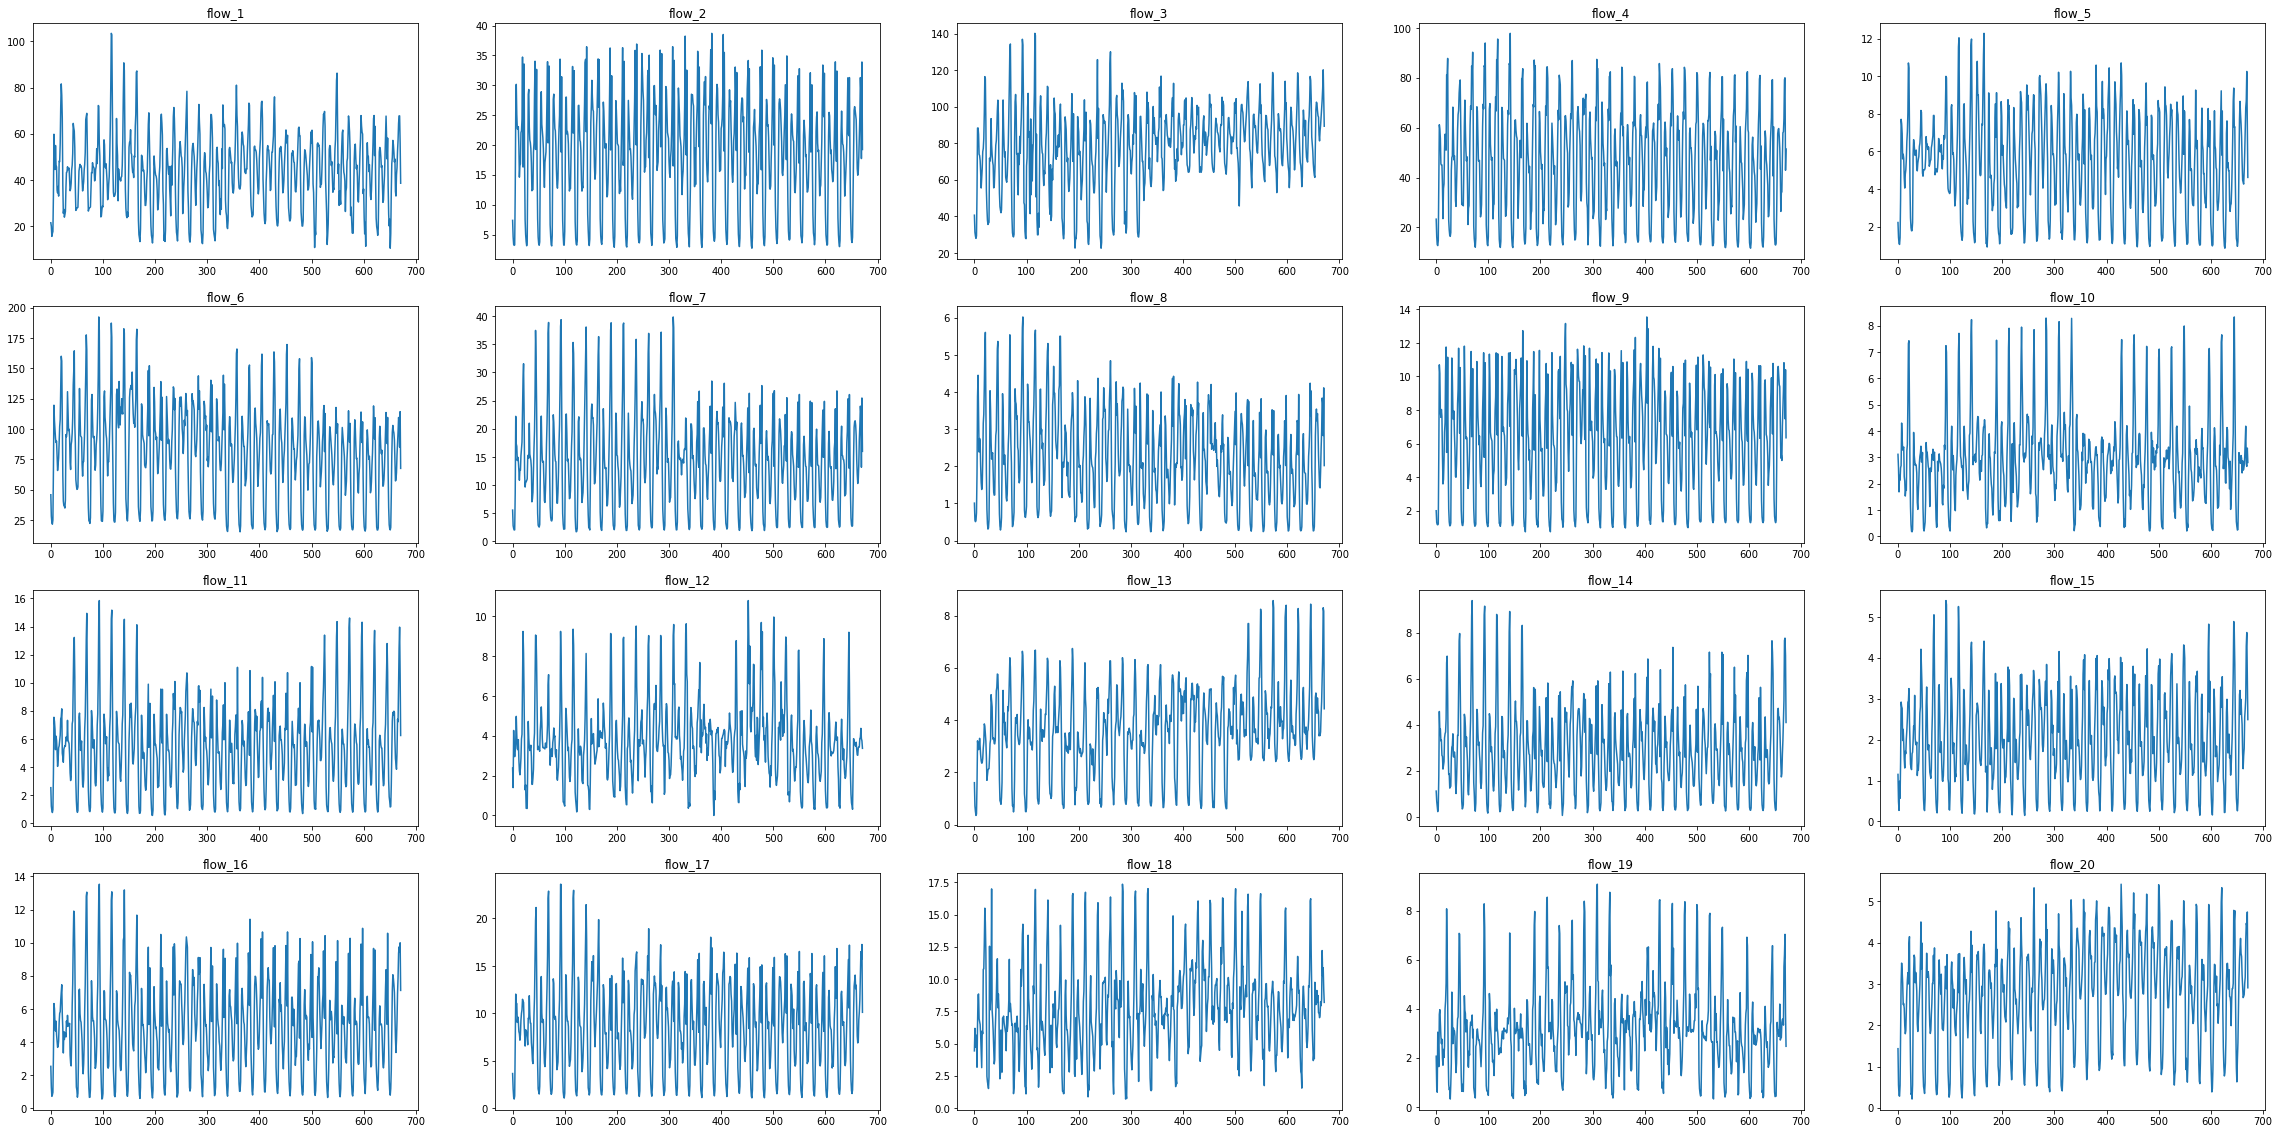

In [279]:
result = np.concatenate((np.vstack(predictions1).transpose(1,0),
                         np.vstack(predictions2).transpose(1,0),
                         np.vstack(predictions3).transpose(1,0),
                         np.vstack(predictions4).transpose(1,0)))
result[result<0]=0
result = pd.concat([sub['time'],pd.DataFrame(result)],axis=1)
result.columns = sub.columns
result.to_csv('./lgb_baseline.csv',index=False,encoding='utf-8')

plt.figure(figsize=(40, 20))
for i in range(1,21):
    flow = f'flow_{i}'
    plt.subplot(4, 5, i)
    plt.plot(range(len(result[flow])), result[flow])
    plt.title(flow)

In [280]:
avg_scores1 = 1 / (1 + sum(scores1)/len(scores1))
print(scores1, avg_scores1)

avg_scores2 = 1 / (1 +sum(scores2)/len(scores2))
print(scores2, avg_scores2)

avg_scores3 = 1 / (1 + sum(scores3)/len(scores3))
print(scores3, avg_scores3)

avg_scores4 = 1 / (1 +sum(scores4)/len(scores4))
print(scores4, avg_scores4)

[0.098, 0.016, 0.388, 0.062, 0.056, 0.062, 0.042, 0.018, 0.016, 0.041, 0.015, 0.034, 0.032, 0.03, 0.023, 0.016, 0.019, 0.096, 0.043, 0.021] 0.9466111321469141
[0.043, 0.012, 0.016, 0.013, 0.04, 0.009, 0.02, 0.03, 0.013, 0.065, 0.022, 0.057, 0.018, 0.022, 0.024, 0.016, 0.029, 0.061, 0.032, 0.019] 0.9727153348572541
[0.045, 0.023, 0.006, 0.016, 0.017, 0.007, 0.019, 0.024, 0.011, 0.019, 0.014, 0.075, 0.023, 0.022, 0.016, 0.014, 0.015, 0.056, 0.053, 0.011] 0.9762764814995607
[0.061, 0.011, 0.004, 0.004, 0.02, 0.017, 0.014, 0.012, 0.011, 0.035, 0.008, 0.047, 0.01, 0.02, 0.015, 0.013, 0.014, 0.037, 0.031, 0.019] 0.9802480027446943


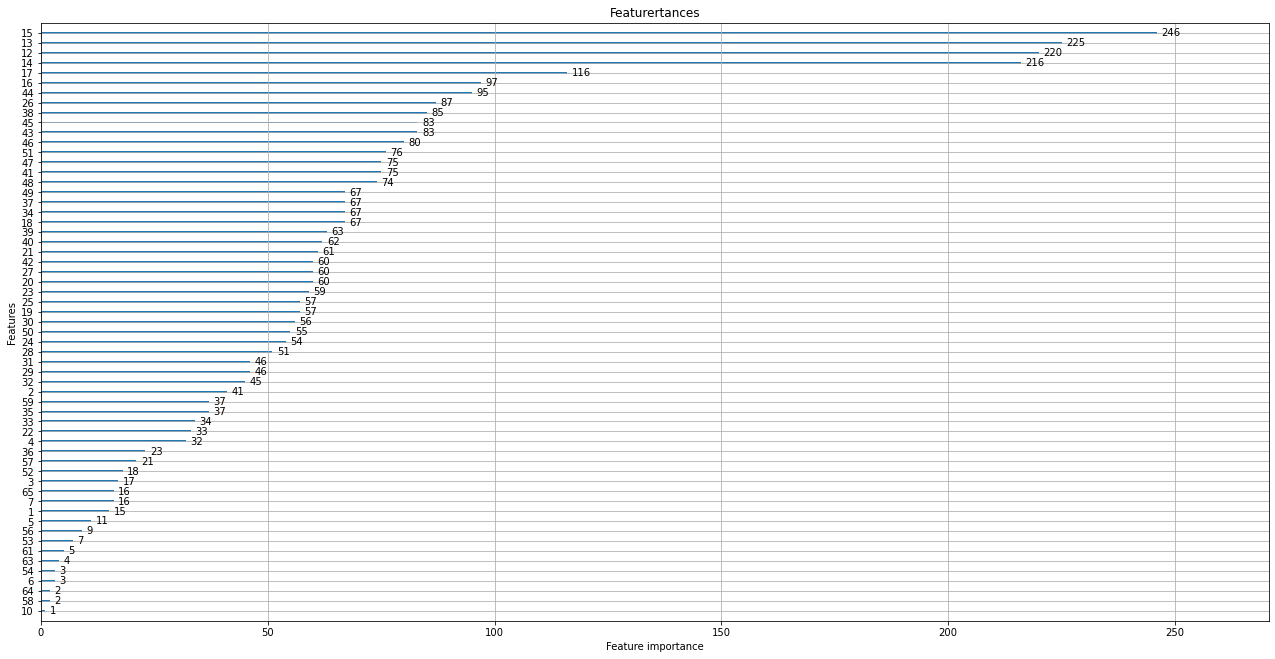

In [284]:
model = lgb_model_list1[0]
lgb.plot_importance(model,figsize=(22,11))
plt.title("Featurertances")
plt.show()